In [6]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
np.random.seed(723)
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

import subtle.subtle_dnn as sudnn
import subtle.subtle_io as suio
import subtle.subtle_generator as sugen
import subtle.subtle_loss as suloss
import subtle.subtle_plot as suplot
import subtle.subtle_preprocess as supre
import subtle.subtle_metrics as sumetrics

from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model as KerasModel

from tqdm import tqdm_notebook as tqdm

from keract import get_activations, display_activations, display_heatmaps
from keras.utils.vis_utils import plot_model

def show_img(img, title='', axis=False, vmin=None, vmax=None, cmap='gray'):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args, cmap=cmap)
    plt.title(title, fontsize=15)

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

    
def combined_model(gen, dis, input_shape):
    inputs = Input(shape=input_shape)
    gen_img = gen(inputs)
    outputs = dis(gen_img)
    
    model = KerasModel(inputs=inputs, outputs=[gen_img, outputs])
    return model
    
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

<Figure size 432x288 with 0 Axes>

In [2]:
data_list = suio.get_data_list(
    '/home/srivathsa/projects/SubtleGad/data_lists/data_train_tiantan_sri.txt',
    file_ext='h5', data_dir='/home/srivathsa/projects/studies/gad/tiantan_pp/data'
)

train_loader = sugen.DataGenerator(
    data_list=data_list[:6],
    batch_size=8,
    shuffle=False,
    verbose=1,
    residual_mode=False,
    slices_per_input=7
)

val_loader = sugen.DataGenerator(
    data_list=data_list[6:],
    batch_size=8,
    shuffle=False,
    verbose=1,
    residual_mode=False,
    slices_per_input=7
)

In [3]:
sudnn.clear_keras_memory()
sudnn.set_keras_memory(1.0)

loss_function = suloss.mixed_loss(l1_lambda=0.8, ssim_lambda=0.2)
metrics_monitor = [suloss.l1_loss, suloss.ssim_loss, suloss.mse_loss]

m_gen = sudnn.DeepEncoderDecoder2D(
    num_channel_input=14, num_channel_output=1,
    img_rows=240, img_cols=240,
    num_filters_first_conv=32,
    loss_function=loss_function,
    metrics_monitor=metrics_monitor,
    lr_init=0.001,
    batch_norm=0,
    verbose=2,
    use_respath=True,
    compile_model=False
)
gen = m_gen.model

m_dis = sudnn.Discriminator(
    img_rows=240, img_cols=240,
    verbose=True, compile_model=False
)

dis = m_dis.model

gen_dis = combined_model(gen, dis, (240, 240, 14))

dis.trainable = True
dis.compile(loss='binary_crossentropy', optimizer=Adam())
dis.trainable = False

gen_dis.compile(loss=[loss_function, 'binary_crossentropy'], optimizer=Adam())#, metrics=metrics_monitor)
dis.trainable = True

data_len = train_loader.__len__()
D_num = 3

real = np.ones((8, 1))
fake = np.zeros((8, 1))

best_gen = None
min_loss = 1e5

for epoch in np.arange(10):
    indices = np.random.permutation(data_len)
    gan_losses = []
    d_losses = []
    g_losses = []
    print('epoch #', epoch)
    for idx in tqdm(indices, total=data_len):
        X, Y = train_loader.__getitem__(idx)
        
        gen_imgs = gen.predict(X)
        
        dis_inp = np.concatenate([Y, gen_imgs])
        dis_out = np.concatenate([real, fake])
        dloss = dis.train_on_batch(dis_inp, dis_out)
        d_losses.append(dloss)

        dis.trainable = False
        gan_loss = gen_dis.train_on_batch(X, [Y, real])
        gan_losses.append(gan_loss)
        dis.trainable = True
    
    gan_losses = np.array(gan_losses)
    print('train loss - gen loss {} | disc_loss {}'.format(gan_losses[:, 0].mean(), np.mean(d_losses)))
    
    print('validation...')
    
    val_data_len = val_loader.__len__()
    val_idxs = np.random.permutation(val_data_len)
    
    val_losses = []
    for idx in tqdm(val_idxs, total=val_data_len):
        X, Y = val_loader.__getitem__(idx)
        
        y_pred = gen.predict(X)
        
        val_loss = np.mean(np.abs(Y[..., 0] - y_pred[..., 0]))
        val_losses.append(val_loss)
    
    epoch_loss = np.mean(val_losses)
    
    print('val L1 loss {}'.format(epoch_loss))
    
    if epoch_loss < min_loss:
        print('Saving best model in this epoch...')
        min_loss = epoch_loss
        gen.save_weights('adv_best.h5')

W0827 15:05:46.287970 139896151525184 deprecation_wrapper.py:119] From /home/srivathsa/miniconda3/envs/py35gad/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0827 15:05:46.288905 139896151525184 deprecation_wrapper.py:119] From /home/srivathsa/miniconda3/envs/py35gad/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0827 15:05:46.305897 139896151525184 deprecation_wrapper.py:119] From /home/srivathsa/miniconda3/envs/py35gad/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 15:05:46.306884 139896151525184 deprecation_wrapper.py:119] From /home/srivathsa/projects/SubtleGad/subtle/subtle_dnn.py:34: The name tf.ConfigProt

Building respath model...


W0827 15:05:46.958191 139896151525184 deprecation_wrapper.py:119] From /home/srivathsa/miniconda3/envs/py35gad/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



Tensor("conv2d_41/BiasAdd:0", shape=(?, 240, 240, 1), dtype=float32)


W0827 15:05:48.123344 139896151525184 deprecation_wrapper.py:119] From /home/srivathsa/miniconda3/envs/py35gad/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("batch_normalization_3/cond/Merge:0", shape=(?, 60, 60, 64), dtype=float32)


W0827 15:05:48.644357 139896151525184 deprecation_wrapper.py:119] From /home/srivathsa/miniconda3/envs/py35gad/lib/python3.5/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 15:05:48.652077 139896151525184 deprecation.py:323] From /home/srivathsa/miniconda3/envs/py35gad/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("batch_normalization_5/cond/Merge:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("batch_normalization_7/cond/Merge:0", shape=(?, 15, 15, 256), dtype=float32)
Tensor("leaky_re_lu_9/LeakyRelu:0", shape=(?, 512), dtype=float32)
Tensor("dense_2/Sigmoid:0", shape=(?, 1), dtype=float32)


In [4]:
fpath_h5 = '/home/srivathsa/projects/studies/gad/tiantan_pp/data/NO29.h5'

gen.load_weights('/home/srivathsa/projects/studies/gad/tiantan_pp/train/checkpoints/mres_adv.h5')

prediction_generator = sugen.DataGenerator(
    data_list=[fpath_h5],
    batch_size=1,
    shuffle=False,
    verbose=0,
    residual_mode=False,
    slices_per_input=7
)

y_pred = gen.predict_generator(prediction_generator)

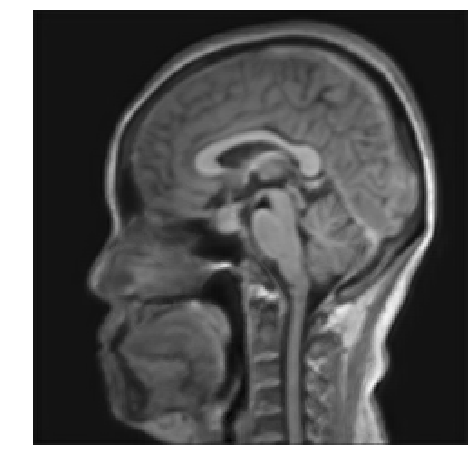

In [7]:
show_img(y_pred[98, ..., 0])

In [ ]:
show_img(study_data[98, 1])